Problem Statement

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.

Load libraries

In [974]:
#import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

Load and read datasets

In [975]:
#load files:-
train  = pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/Identify-Disaster-through-Twitter/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/Identify-Disaster-through-Twitter/master/test.csv')
sample_sub=pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/Identify-Disaster-through-Twitter/master/sample_submission.csv')

In [976]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [977]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [978]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [979]:
sample_sub

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


Analyse target

In [980]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [981]:
from collections import Counter

print(Counter(train['target']))

Counter({0: 4342, 1: 3271})


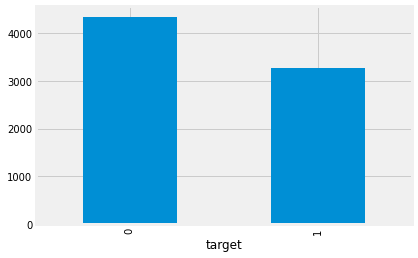

In [982]:
train.groupby('target').text.count().plot.bar(ylim=0)
plt.show()

Check for null values

In [983]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [984]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Impute null values

In [985]:
#replace columns with mode
for column in train.columns:
    train[column].fillna("unknown", inplace=True)

for column in test.columns:
    test[column].fillna("unknown", inplace=True)

Preprocess data

In [986]:
# Importing HTMLParser
from html.parser import HTMLParser

html_parser = HTMLParser()

In [987]:
# Created a new columns i.e. clean_tweet contains the same tweets but cleaned version
train['tidy_text'] = train['text'].apply(lambda x: html_parser.unescape(x))
test['tidy_text'] = test['text'].apply(lambda x: html_parser.unescape(x))

Count words to preprocess

In [988]:
train['tidy_text'].apply(lambda x: len(x.split(' '))).sum()

113654

In [989]:
test['tidy_text'].apply(lambda x: len(x.split(' '))).sum()

48876

In [990]:
import re

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [991]:
# remove twitter handles (@user)
train['tidy_text'] = np.vectorize(remove_pattern)(train['text'], "@[\w]*")
test['tidy_text'] = np.vectorize(remove_pattern)(test['text'], "@[\w]*")

In [992]:
#changing all tweets into lower case
train['tidy_text'] = train['tidy_text'].apply(lambda x: x.lower())
test['tidy_text'] = test['tidy_text'].apply(lambda x: x.lower())

In [993]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
apostrophe_dict

{"'cause": 'because',
 "ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

In [994]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [995]:
train['tidy_text'] = train['tidy_text'].apply(lambda x: lookup_dict(x,apostrophe_dict))
test['tidy_text'] = test['tidy_text'].apply(lambda x: lookup_dict(x,apostrophe_dict))

In [996]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [997]:
train['tidy_text'] = train['tidy_text'].apply(lambda x: lookup_dict(x,short_word_dict))
test['tidy_text'] = test['tidy_text'].apply(lambda x: lookup_dict(x,short_word_dict))

In [998]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}
emoticon_dict

{'8-)': 'happy',
 ':(': 'sad',
 ':)': 'happy',
 ':-(': 'sad',
 ':-3': 'happy',
 ':-< ': 'sad',
 ':->': 'happy',
 ':-[': 'sad',
 ':-]': 'happy',
 ':-c': 'sad',
 ':-||': 'sad',
 ':-}': 'happy',
 ':<': 'sad',
 ':[': 'sad',
 ':^)': 'happy',
 ':c': 'sad',
 ':c)': 'happy',
 ':o)': 'happy',
 ':{': 'sad',
 ':‑)': 'happy',
 '<3': 'happy',
 '=)': 'happy',
 '=]': 'happy',
 '>:(': 'sad',
 '>:[': 'sad'}

In [999]:
train['tidy_text'] = train['tidy_text'].apply(lambda x: lookup_dict(x,emoticon_dict))
test['tidy_text'] = test['tidy_text'].apply(lambda x: lookup_dict(x,emoticon_dict))

In [1000]:
#disaster word dictionaty
disaster_dict = {
"ablaze": "ablaze disaster",
"accident": "accident disaster",
"accidents": "accidents disaster",
"aftershock": "aftershock disaster",
"ambulance": "ambulance disaster",
"ambulances": "ambulances disaster",
"annihilate": "annihilate disaster",
"annihilated": "annihilated disaster",
"annihilates": "annihilates disaster",
"annihilation": "annihilation disaster",
"apocalypse": "apocalypse disaster",
"armies": "armies disaster",
"army": "army disaster",
"armageddon": "armageddon disaster",
"arson": "arson disaster",
"arsonist": "arsonist disaster",
"attack": "attack disaster",
"attacked": "attacked disaster",
"attacks": "attacks disaster",
"avalanche": "avalanche disaster",
"bang": "bang disaster",
"battle": "battle disaster",
"bioterror": "bioterror disaster",
"bioterrorism": "bioterrorism disaster",
"bioterrorist": "bioterrorist disaster",
"blaze": "blaze disaster",
"blazed": "blazed disaster",
"blazen": "blazen disaster",
"blazes": "blazes disaster",
"blazing": "blazing disaster",
"bleed": "bleed disaster",
"bleeding": "bleeding disaster",
"blight": "blight disaster",
"blighted": "blighted disaster",
"blighting": "blighting disaster",
"blights": "blights disaster",
"blizzard": "blizzard disaster",
"blizzards": "blizzards disaster",
"blood": "blood disaster",
"bloody": "bloody disaster",
"bodybag": "bodybag disaster",
"bodybags": "bodybags disaster",
"bomb": "bomb disaster",
"bomber": "bomber disaster",
"bombing": "bombing disaster",
"bombs": "bombs disaster",
"burn": "burn disaster",
"burned": "burned disaster",
"burning": "burning disaster",
"burns": "burns disaster",
"burnt": "burnt disaster",
"casualties": "casualties disaster",
"casualty": "casualty disaster",
"catastrophe": "catastrophe disaster",
"catastrophic": "catastrophic disaster",
"chemical": "chemical disaster",
"chemicals": "chemicals disaster",
"cliff": "cliff disaster",
"cliffhanger": "cliffhanger disaster",
"cliffs": "cliffs disaster",
"collapse": "collapse disaster",
"collapsed": "collapsed disaster",
"collide": "collide disaster",
"collided": "collided disaster",
"collision": "collision disaster",
"crash": "crash disaster",
"crashed": "crashed disaster",
"crush": "crush disaster",
"crushed": "crushed disaster",
"curfew": "curfew disaster",
"cyclone": "cyclone disaster",
"danger": "danger disaster",
"dangerous": "dangerous disaster",
"dangerzone": "dangerzone disaster",
"dead": "dead disaster",
"death": "death disaster",
"demolish": "demolish disaster",
"demolished": "demolishes disaster",
"demolishes": "demolishes disaster",
"demolishing": "demolishing disaster",
"died": "died disaster",
"debris":  "debris disaster",
"derail": "derail disaster",
"derailed": "derailed disaster",
"destroy": "destroy disaster",
"destroyed": "destroyed disaster",
"destroying": "destroying disaster",
"destroys": "destroys disaster",
"derailment": "derailment disaster",
"detonate": "detonate disaster",
"detonated": "detonated disaster",
"detonates": "detonates disaster",
"detonating": "detonating disaster",
"detonation": "detonation disaster",
"devastated": "devastated disaster",
"devastation": "devastation disaster",
"damage": "damage disaster",
"damaged": "damaged disaster",
"damages": "damages disaster",
"deluge": "deluge disaster",
"deluged": "deluged disaster",
"demolish": "demolish disaster",
"demolished": "demolished disaster",
"demolition": "demolition disaster",
"desolate": "desolate disaster",
"destruction": "destruction disaster",
"disaster": "disaster disaster",
"disasters": "disasters disaster",
"displace": "displace disaster",
"displaced": "displaced disaster",
"drought": "drought disaster",
"drown": "drown disaster",
"drowned": "drowned disaster",
"drowning": "drowning disaster",
"drowns": "drowns disaster",
"earthquake": "earthquake disaster",
"earthquakes": "earthquake disaster",
"electrocute": "electrocute disaster",
"electrocuted": "electrocuted disaster",
"electrocutes": "electrocutes disaster",
"electrocuting": "electrocuting disaster",
"emergency": "emergency disaster",
"emergencies": "emergencies disaster",
"engulf": "engulf disaster",
"engulfed": "engulfed disaster",
"engulfing": "engulfing disaster",
"evacuate": "evacuate disaster",
"evacuated": "evacuated disaster",
"explode": "explode disaster",
"exploded": "exploded disaster",
"explodes": "explodes disaster",
"exploding": "exploding disaster",
"explosion": "explosion disaster",
"eyewitness": "eyewitness disaster",
"eyewitnesses": "eyewitnesses disaster",
"eyewitnessed": "eyewitnessed disaster",
"fail": "fail disaster",
"failed": "failed disaster",
"failure": "failure disaster",
"fall": "fall disaster",
"falling": "falling disaster",
"famine": "famine disaster",
"fatal": "fatal disaster",
"fatalities": "fatalities disaster",
"fatality": "fatality disaster",
"fear": "fear disaster",
"feared": "feared disaster",
"fearful": "fearful disaster",
"fears": "fears disaster",
"fearsome": "fearsome disaster",
"fell": "fell disaster",
"fire": "fire disaster",
"fires": "fires disaster",
"flame": "flame disaster",
"flames": "flames disaster",
"flaming": "flaming disaster",
"flood": "flood disaster",
"flooded": "flooded disaster",
"flooding": "flooding disaster",
"floods": "floods disaster",
"hail": "hail disaster",
"hailed": "hailed disaster",
"hailing": "hailing disaster",
"hails": "hails disaster",
"hailstorm": "hailstorm disaster",
"hailstormed": "hailstormed disaster",
"hailstorming": "hailstorming disaster",
"hailstorms": "hailstorms disaster",
"harm": "harm disaster",
"harmed": "harmed disaster",
"harming": "harming disaster",
"harms": "harms disaster",
"hazard": "hazard disaster",
"hazardous": "hazardous disaster",
"heatwave": "heatwave disaster",
"hell": "hell disaster",
"hellfire": "hellfire disaster",
"hijack": "hijack disaster",
"hijacked": "hijacked disaster",
"hijacker": "hijacker disaster",
"hijacking": "hijacking disaster",
"hostage": "hostage disaster",
"hostages": "hostages disaster",
"hurricane": "hurricane disaster",
"hurricanes": "hurricanes disaster",
"injure": "injure disaster",
"injured": "injured disaster",
"injures": "injures disaster",
"injuries": "injuries disaster",
"injuring": "injuring disaster",
"injury": "injury disaster",
"inundate": "inundate disaster",
"inundated": "inundated disaster",
"inundation": "inundation disaster",
"landslide": "landslide disaster",
"landslides": "landslides disaster",
"lava": "lava disaster",
"lightning": "lightning disaster",
"massacre": "massacre disaster",
"massacred": "massacred disaster",
"massacres": "massacres disaster",
"mayhem": "mayhem disaster",
"meltdown": "meltdown disaster",
"meltdowns": "meltdowns disaster",
"military": "military disaster",
"militarise": "militarise disaster",
"militarize": "militarize disaster",
"mudslide": "mudslide disaster",
"mudslides": "mudslides disaster",
"murder": "murder disaster",
"murdered": "murdered disaster",
"murderer": "murderer disaster",
"murderers": "murderers disaster",
"murders": "murders disaster",
"nuclear": "nuclear disaster",
"obliterate": "obliterate disaster",
"obliterated": "obliterated disaster",
"obliterates": "obliterates disaster",
"obliterating": "obliterating disaster",
"obliteration": "obliteration disaster",
"outbreak": "outbreak disaster",
"pandemonium": "pandemonium disaster",
"panic": "panic disaster",
"panicked": "panicked disaster",
"panicking": "panicking disaster",
"panics": "panics disaster",
"police": "police disaster",
"policeman": "policeman disaster",
"policemen": "policemen disaster",
"rainstorm": "rainstorm disaster",
"quarantine": "quarantine disaster",
"quarantined": "quarantined disaster",
"quarantines": "quarantines disaster",
"quarantining": "quarantining disaster",
"rainstormed": "rainstormed disaster",
"rainstorming": "rainstorming disaster",
"rainstorms": "rainstorms disaster",
"radiation": "radiation disaster",
"raze": "raze disaster",
"razed": "razed disaster",
"reactor": "reactor disaster",
"reactors": "reactors disaster",
"refugee": "refugee disaster",
"refugees": "refugees disaster",
"rescue": "rescue disaster",
"rescued": "rescued disaster",
"rescuer": "rescuer disaster",
"rescuing": "rescuing disaster",
"responder": "responder disaster",
"responders": "responders disaster",
"riot": "riot disaster",
"rioted": "rioted disaster",
"rioting": "rioting disaster",
"riots": "riots disaster",
"rubble": "rubble disaster",
"ruin": "ruin disaster",
"ruined": "ruined disaster",
"ruining": "ruining disaster",
"ruins": "ruins disaster",
"scream": "scream disaster",
"screamed": "screamed disaster",
"screaming": "screaming disaster",
"screams": "screams disaster",
"seismic": "seismic disaster",
"sank": "sank disaster",
"sink": "sink disaster",
"sinking": "sinking disaster",
"sunk": "sunk disaster",
"sinkhole": "sinkhole disaster",
"sinkholes": "sinkholes disaster",
"siren": "siren disaster",
"sirens": "sirens disaster",
"smoke": "smoke disaster",
"smoked": "smoked disaster",
"smoking": "smoking disaster",
"smokes": "smokes disaster",
"snow": "snow disaster",
"snowed": "snowed disaster",
"snowing": "snowing disaster",
"snows": "snows disaster",
"snowstorm": "snowstorm disaster",
"snowstormed": "snowstormed disaster",
"snowstorming": "snowstorming disaster",
"snowstorms": "snowstorms disaster",
"spill": "spill disaster",
"starvation": "starvation disaster",
"starve": "starve disaster",
"storm": "storm disaster",
"stormed": "stormed disaster",
"storming": "storming disaster",
"storms": "storms disaster",
"stretcher": "stretcher disaster",
"suicide": "suicide disaster",
"survive": "survive disaster",
"survived": "survived disaster",
"survives": "survives disaster",
"surviving": "surviving disaster",
"survivor": "survivor disaster",
"survivors": "survivors disaster",
"terror": "terror disaster",
"terrorism": "terrorism disaster",
"terrorist": "terrorist disaster",
"threat": "threat disaster",
"threaten": "threaten disaster",
"thunder": "thunder disaster",
"thundered": "thundered disaster",
"thundering": "thundering disaster",
"thunders": "thunders disaster",
"thunderstorm": "thunderstorm disaster",
"thunderstormed": "thunderstormed disaster",
"thunderstorming": "thunderstorming disaster",
"thunderstorms": "thunderstorms disaster",
"tornado": "tornado disaster",
"tornados": "tornados disaster",
"tragic": "tragic disaster",
"tragedy": "tragedy disaster",
"trap": "trap disaster",
"trapped": "trapped disaster",
"trapping": "trapping disaster",
"traps": "traps disaster",
"trauma": "trauma disaster",
"traumatise": "traumatise disaster",
"traumatised": "traumatised disaster",
"traumatises": "traumatises disaster",
"traumatising": "traumatising disaster",
"traumatize": "traumatize disaster",
"traumatized": "traumatized disaster",
"traumatizing": "traumatizing disaster",
"traumatizes": "traumatizes disaster",
"trouble": "trouble disaster",
"troubles": "troubles disaster",
"tsunami": "tsunami disaster",
"tsunamis": "tsunamis disaster",
"twister": "twister disaster",
"twisters": "twisters disaster",
"typhoon": "typhoon disaster",
"upheaval": "upheaval disaster",
"violence": "violence disaster",
"violent": "violent disaster",
"volcanic": "volcanic disaster",
"volcano": "volcano disaster",
"war": "war disaster",
"warred": "warred disaster",
"warring": "warring disaster",
"wars": "wars disaster",
"weapon": "weapon disaster",
"weaponize": "weaponize disaster",
"weaponise": "weaponise disaster",
"weapons": "weapons disaster",
"whirlwind": "whirlwind disaster",
"wildfire": "wildfire disaster",
"wildfires": "wildfires disaster",
"windstorm": "windstorm disaster",
"windstormed": "windstormed disaster",
"windstorming": "windstorming disaster",
"windstorms": "windstorms disaster",
"wound": "wound disaster",
"wounded": "wounded disaster",
"wounding": "wounding disaster",
"wounds": "wounds disaster",
"wreck": "wreck disaster",
"wreckage": "wreckage disaster",
"wrecked": "wrecked disaster",
}

In [1001]:
train['tidy_text'] = train['tidy_text'].apply(lambda x: lookup_dict(x,disaster_dict))
test['tidy_text'] = test['tidy_text'].apply(lambda x: lookup_dict(x,disaster_dict))

In [1002]:
# remove special characters, numbers, punctuations
train['tidy_text'] = train['tidy_text'].str.replace("[^a-zA-Z#]", " ")
test['tidy_text'] = test['tidy_text'].str.replace("[^a-zA-Z#]", " ")

In [1003]:
#remove rare words
freq_train = pd.Series(''.join(train['tidy_text']).split()).value_counts()
freq_train = list(freq_train.index)
f = lambda x:" ".join(x for x in x.split() if x in freq_train)
train['tidy_text'] = train['tidy_text'].apply(f)

freq_test = pd.Series(''.join(test['tidy_text']).split()).value_counts()
freq_test = list(freq_test.index)
f = lambda x:" ".join(x for x in x.split() if x in freq_test)
test['tidy_text'] = test['tidy_text'].apply(f)

In [1004]:
#remove words with length of 2 or less
train['tidy_text'] = train['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
test['tidy_text'] = test['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [1006]:
from nltk.tokenize import word_tokenize

tokenized_train_tweet = train['tidy_text'].apply(lambda x: x.split())
tokenized_test_tweet = test['tidy_text'].apply(lambda x: x.split())

Stem and remove stop words

In [1007]:
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

stemmer = PorterStemmer()
words = stopwords.words("english")

train['tidy_text'] = train['tidy_text'].apply(lambda x: " ".join([stemmer.stem(i) 
for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

test['tidy_text'] = test['tidy_text'].apply(lambda x: " ".join([stemmer.stem(i) 
for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1008]:
for i in range(len(tokenized_train_tweet)):
    tokenized_train_tweet[i] = ' '.join(tokenized_train_tweet[i])
train['tidy_text'] = tokenized_train_tweet

for i in range(len(tokenized_test_tweet)):
    tokenized_test_tweet[i] = ' '.join(tokenized_test_tweet[i])
test['tidy_text'] = tokenized_test_tweet

Count words to analyse

In [1009]:
train['tidy_text'].apply(lambda x: len(x.split(' '))).sum()

100892

In [1010]:
test['tidy_text'].apply(lambda x: len(x.split(' '))).sum()

43155

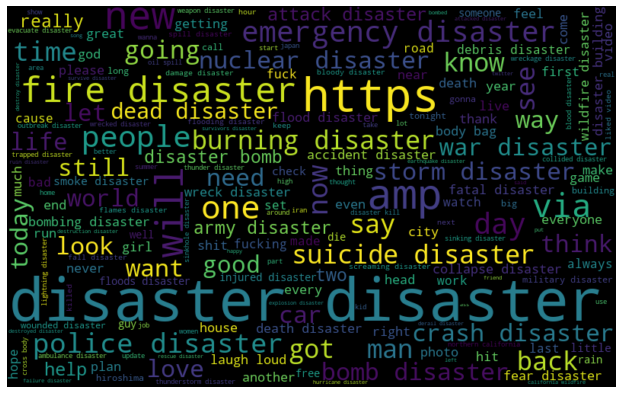

In [1011]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in train['tidy_text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

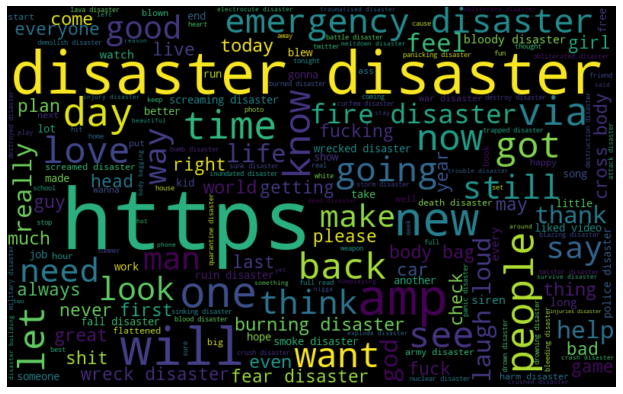

In [1012]:
normal_words =' '.join([text for text in train['tidy_text'][train['target'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

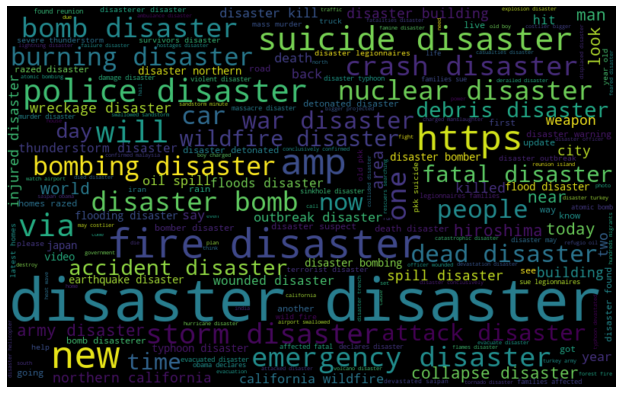

In [1013]:
negative_words = ' '.join([text for text in train['tidy_text'][train['target'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [1014]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [1015]:
# extracting hashtags from normal tweets
HT_train_regular = hashtag_extract(train['tidy_text'][train['target'] == 0])
HT_test_regular = hashtag_extract(test['tidy_text'] [train['target'] == 0])

# extracting hashtags from negative tweets
HT_train_negative = hashtag_extract(train['tidy_text'][train['target'] == 1])
HT_test_negative = hashtag_extract(test['tidy_text'][train['target'] == 1])

# unnesting tweets
HT_train_regular = sum(HT_train_regular,[])
HT_test_regular = sum(HT_test_regular,[])

HT_train_negative = sum(HT_train_negative,[])
HT_test_negative = sum(HT_test_negative,[])

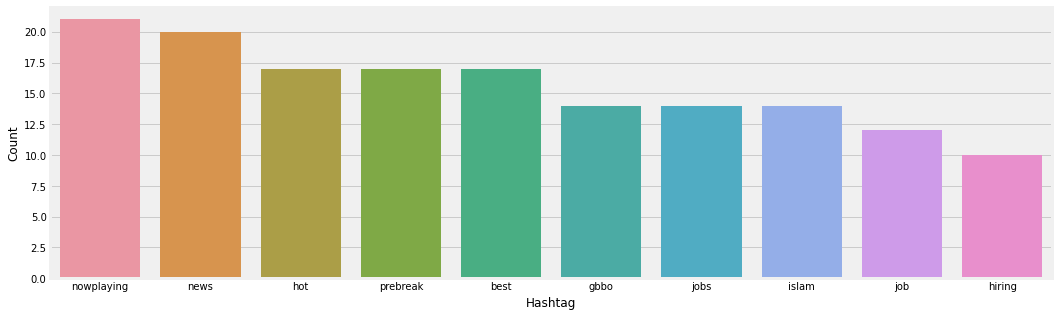

In [1016]:
#positive tweets
a = nltk.FreqDist(HT_train_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

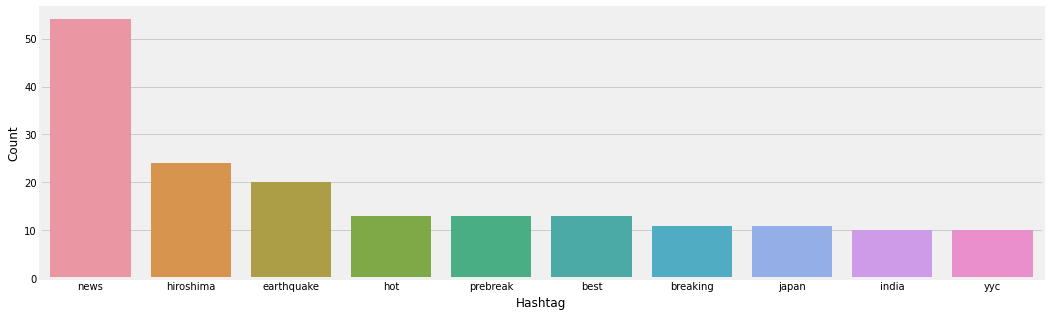

In [1017]:
#negative tweets
b = nltk.FreqDist(HT_train_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

Define X, y and X_test

In [1018]:
y = train.target
X = train.tidy_text
X_test = test.tidy_text

Split train dataset for training and validation

In [1019]:
from sklearn.model_selection import train_test_split

#split into training and valodation set
X_train, X_val, y_train, y_val=train_test_split(X, y, random_state=42, test_size = 0.1, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6851,), (762,), (6851,), (762,))

Create pipeline

In [1020]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

model = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LinearSVC(class_weight='balanced',C=0.5)),
              ])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LinearSVC(C=0.5, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [1021]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred))


accuracy 0.7782152230971129
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       426
           1       0.75      0.74      0.75       336

    accuracy                           0.78       762
   macro avg       0.78      0.77      0.77       762
weighted avg       0.78      0.78      0.78       762



In [1022]:
prediction = model.predict(X_test)
prediction

array([1, 1, 1, ..., 1, 1, 1])

In [1023]:
submit = pd.DataFrame({'id': test.id, 'target': prediction})
submit

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [1024]:
submit.to_csv('submission.csv', index=False)